<a href="https://colab.research.google.com/github/hjangir080/EmotionAwareMusicGeneration/blob/main/v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 1

# Import Libraries and install dependencies

In [ ]:
!pip install torch torchtext nltk transformers pandas matplotlib scikit-learn librosa pydub midiutil pretty_midi

In [23]:
import gutenbergpy.textget
import nltk
import torch
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
import shutil
# Delete any old nltk data
shutil.rmtree('/root/nltk_data', ignore_errors=True)
nltk.download("punkt")

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.preprocessing import MinMaxScaler
import json
import os
from google.colab import files
from midiutil import MIDIFile
import pretty_midi
import IPython.display as ipd
import random
import librosa
from pydub import AudioSegment
from pydub.playback import play
import io
import base64
import tempfile

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Make sure the above downloads complete before proceeding
try:
    word_tokenize("Testing NLTK")
    print("NLTK resources downloaded successfully!")
except LookupError:
    print("Downloading additional NLTK resources...")
    # Alternative download method
    !python -m nltk.downloader punkt
    !python -m nltk.downloader stopwords
    !python -m nltk.downloader wordnet

# Text Processing Core (Section A)


**TextProcessor Class** handles:
- Text cleaning (punctuation removal, lemmatization)
- Segmentation into meaningful units
- Stopword removal and normalization  


In [27]:
class TextProcessor:
    def __init__(self):
        # Make sure stopwords are available
        try:
            self.stop_words = set(stopwords.words('english'))
        except LookupError:
            nltk.download('stopwords')
            self.stop_words = set(stopwords.words('english'))

        # Make sure wordnet is available
        try:
            self.lemmatizer = WordNetLemmatizer()
        except LookupError:
            nltk.download('wordnet')
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Remove punctuation, lowercase, remove stopwords, and lemmatize"""
        # Lowercase the text
        text = text.lower()
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)

        # Try to tokenize, with fallback method if it fails
        try:
            # Tokenize into words
            words = word_tokenize(text)
        except LookupError:
            # Fallback: simple space-based tokenization
            words = text.split()

        # Remove stopwords and lemmatize
        cleaned_words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]
        return ' '.join(cleaned_words)

    def segment_text(self, text, segment_size=500):
        """Split text into segments of roughly equal size"""
        try:
            sentences = sent_tokenize(text)
        except LookupError:
            # Fallback: simple period-based sentence splitting
            sentences = [s.strip() + '.' for s in text.split('.') if s.strip()]

        segments = []
        current_segment = []
        current_length = 0

        for sentence in sentences:
            sentence_length = len(sentence)
            if current_length + sentence_length > segment_size and current_segment:
                segments.append(' '.join(current_segment))
                current_segment = [sentence]
                current_length = sentence_length
            else:
                current_segment.append(sentence)
                current_length += sentence_length

        # Add the last segment if it exists
        if current_segment:
            segments.append(' '.join(current_segment))

        return segments

    def process_text(self, text, segment_size=500):
        """Process the full text: segment first, then clean each segment"""
        segments = self.segment_text(text, segment_size)
        cleaned_segments = [self.clean_text(segment) for segment in segments]
        # Also keep the original segments for display purposes
        return segments, cleaned_segments

# Emotion Analysis (Section A)


**EmotionExtractor Class**:
- Uses pre-trained RoBERTa model for emotion detection
- Quantifies emotion intensities per text segment
- Outputs emotional map with intensity scores

In [28]:
class EmotionExtractor:
    def __init__(self):
        # Load pre-trained emotion classification model
        try:
            self.emotion_classifier = pipeline(
                "text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                return_all_scores=True
            )
        except:
            # Handle the warning about return_all_scores being deprecated
            self.emotion_classifier = pipeline(
                "text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                top_k=None  # Using top_k=None instead of return_all_scores=True
            )

        # Define our emotion categories
        self.emotion_categories = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust', 'neutral']

    def extract_emotions(self, text_segments):
        """Extract emotions from text segments"""
        emotion_maps = []

        for segment in text_segments:
            # Get emotion scores for the segment
            emotion_scores = self.emotion_classifier(segment)[0]

            # Convert to dictionary with emotion as key and score as value
            emotion_dict = {item['label']: item['score'] for item in emotion_scores}

            # Map the model's emotions to our simplified set if needed
            mapped_emotions = {
                'joy': emotion_dict.get('joy', 0),
                'sadness': emotion_dict.get('sadness', 0),
                'anger': emotion_dict.get('anger', 0),
                'fear': emotion_dict.get('fear', 0),
                'surprise': emotion_dict.get('surprise', 0),
                'disgust': emotion_dict.get('disgust', 0),
                'neutral': emotion_dict.get('neutral', 0)
            }

            emotion_maps.append(mapped_emotions)

        return emotion_maps

    def create_emotional_progression(self, emotion_maps):
        """Create a time series of emotions for the entire text"""
        progression = {emotion: [] for emotion in self.emotion_categories}

        for emotion_map in emotion_maps:
            for emotion in self.emotion_categories:
                progression[emotion].append(emotion_map[emotion])

        return progression

    def get_dominant_emotions(self, emotion_maps, top_n=2):
        """Get the dominant emotions for each segment"""
        dominant_emotions = []

        for emotion_map in emotion_maps:
            # Sort emotions by score
            sorted_emotions = sorted(emotion_map.items(), key=lambda x: x[1], reverse=True)
            # Take top n emotions
            top_emotions = sorted_emotions[:top_n]
            dominant_emotions.append(top_emotions)

        return dominant_emotions

# Emotion-to-Music Mapping (Sections B & C)



**Core Components**:
- Custom NN for emotion→music feature translation
- Musical feature definitions (tempo, key, instrumentation)
- MusicLM prompt generator

In [29]:
class EmotionToMusicMapper(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, output_dim=10):
        super(EmotionToMusicMapper, self).__init__()

        # Neural network for mapping emotions to musical features
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # Normalized output
        )

        # Define music feature mappings
        self.musical_features = {
            'tempo': {'min': 60, 'max': 180},     # BPM
            'key': {'min': 0, 'max': 11},         # C=0, C#=1, ..., B=11
            'mode': {'min': 0, 'max': 1},         # Minor=0, Major=1
            'intensity': {'min': 0, 'max': 1},    # Soft to loud
            'instrumentation': {'min': 0, 'max': 5},  # Different instrument groups
            'rhythm_complexity': {'min': 0, 'max': 1},
            'harmonic_complexity': {'min': 0, 'max': 1},
            'melodic_range': {'min': 0, 'max': 1},
            'texture': {'min': 0, 'max': 1},      # Sparse to dense
            'articulation': {'min': 0, 'max': 1}  # Staccato to legato
        }

        # Map features to index in output
        self.feature_to_idx = {feature: i for i, feature in enumerate(self.musical_features.keys())}

        # Define emotional correlations (simplified)
        self.emotion_correlations = {
            'joy': {'tempo': 'high', 'mode': 'major', 'intensity': 'moderate-high'},
            'sadness': {'tempo': 'low', 'mode': 'minor', 'intensity': 'low'},
            'anger': {'tempo': 'high', 'mode': 'minor', 'intensity': 'high'},
            'fear': {'tempo': 'variable', 'mode': 'minor', 'intensity': 'variable'},
            'surprise': {'tempo': 'variable', 'mode': 'variable', 'intensity': 'variable'},
            'disgust': {'tempo': 'low-moderate', 'mode': 'minor', 'intensity': 'moderate'},
            'neutral': {'tempo': 'moderate', 'mode': 'variable', 'intensity': 'moderate'}
        }

    def forward(self, emotion_vector):
        """Map emotion vector to musical features"""
        return self.network(emotion_vector)

    def map_to_actual_values(self, normalized_features):
        """Convert normalized outputs to actual musical values"""
        actual_values = {}

        for feature, feature_range in self.musical_features.items():
            idx = self.feature_to_idx[feature]
            norm_value = normalized_features[idx].item()

            # Scale to the actual range
            min_val = feature_range['min']
            max_val = feature_range['max']
            actual_value = min_val + norm_value * (max_val - min_val)

            # Round as needed
            if feature in ['key', 'instrumentation']:
                actual_value = round(actual_value)

            actual_values[feature] = actual_value

        return actual_values

    def generate_musiclm_prompt(self, musical_features):
        """Convert musical features to a MusicLM text prompt"""
        # Map key number to name
        key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        key_name = key_names[round(musical_features['key'])]

        # Map mode number to name
        mode_name = "major" if musical_features['mode'] > 0.5 else "minor"

        # Map instrumentation to instrument types
        instrument_types = ['piano', 'strings', 'guitar', 'synth', 'orchestral', 'percussion']
        instrument = instrument_types[round(musical_features['instrumentation'])]

        # Determine tempo description
        tempo = musical_features['tempo']
        if tempo < 80:
            tempo_desc = "slow"
        elif tempo < 120:
            tempo_desc = "moderate"
        else:
            tempo_desc = "fast"

        # Determine intensity description
        intensity = musical_features['intensity']
        if intensity < 0.3:
            intensity_desc = "soft"
        elif intensity < 0.7:
            intensity_desc = "moderate"
        else:
            intensity_desc = "powerful"

        # Build the prompt
        prompt = f"A {intensity_desc} {tempo_desc} melody in {key_name} {mode_name}, "

        # Add texture
        texture = musical_features['texture']
        if texture < 0.3:
            prompt += "with a sparse arrangement, "
        elif texture > 0.7:
            prompt += "with a dense, layered arrangement, "

        # Add instrumentation
        prompt += f"featuring {instrument}, "

        # Add complexity
        rhythm_complexity = musical_features['rhythm_complexity']
        harmonic_complexity = musical_features['harmonic_complexity']

        if rhythm_complexity > 0.7 and harmonic_complexity > 0.7:
            prompt += "with complex rhythms and harmonies, "
        elif rhythm_complexity > 0.7:
            prompt += "with complex rhythms, "
        elif harmonic_complexity > 0.7:
            prompt += "with rich harmonies, "
        elif rhythm_complexity < 0.3 and harmonic_complexity < 0.3:
            prompt += "with simple, straightforward patterns, "

        # Add articulation
        articulation = musical_features['articulation']
        if articulation < 0.3:
            prompt += "played with staccato articulation."
        elif articulation > 0.7:
            prompt += "played with smooth, legato phrasing."
        else:
            prompt += "with balanced articulation."

        return prompt

# Temporal Coherence (Section E)



**Key Features**:
- LSTM-based sequence modeling
- Ensures smooth musical transitions
- Handles evolving emotional dynamics  

In [30]:
class TemporalCoherenceModel(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=64, output_dim=10):
        super(TemporalCoherenceModel, self).__init__()

        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, sequence):
        """Process a sequence of musical features to ensure temporal coherence"""
        # Expected shape: [batch_size, sequence_length, features]
        lstm_out, _ = self.lstm(sequence)

        # Apply output layer to each time step
        coherent_sequence = self.output_layer(lstm_out)

        return coherent_sequence

# MIDI generation

In [31]:
class MusicGenerator:
    def __init__(self):
        # MIDI settings
        self.instruments = {
            'piano': 0,       # Acoustic Grand Piano
            'strings': 48,    # String Ensemble 1
            'guitar': 24,     # Acoustic Guitar (nylon)
            'synth': 80,      # Lead 1 (square)
            'orchestral': 48, # String Ensemble 1
            'percussion': 118 # Synth Drum
        }

        # Scales (for different keys and modes)
        self.major_scale = [0, 2, 4, 5, 7, 9, 11]  # Whole, Whole, Half, Whole, Whole, Whole, Half
        self.minor_scale = [0, 2, 3, 5, 7, 8, 10]  # Whole, Half, Whole, Whole, Half, Whole, Whole

        # Common chord progressions
        self.progressions = {
            'major': [
                [1, 4, 5, 1],       # I-IV-V-I
                [1, 6, 4, 5],       # I-vi-IV-V
                [1, 5, 6, 4],       # I-V-vi-IV
                [2, 5, 1, 6]        # ii-V-I-vi
            ],
            'minor': [
                [1, 4, 5, 1],       # i-iv-v-i
                [1, 6, 3, 7],       # i-VI-III-VII
                [1, 7, 6, 5],       # i-VII-VI-v
                [1, 4, 7, 3]        # i-iv-VII-III
            ]
        }

    def create_midi_from_features(self, musical_features, duration_seconds=15):
        """Generate MIDI file from musical features"""
        # Extract features
        tempo = musical_features['tempo']
        key = int(musical_features['key'])
        mode = 'major' if musical_features['mode'] > 0.5 else 'minor'
        instrument_type = ['piano', 'strings', 'guitar', 'synth', 'orchestral', 'percussion'][int(musical_features['instrumentation'])]
        instrument = self.instruments[instrument_type]

        # Derived parameters
        rhythm_complexity = musical_features['rhythm_complexity']
        harmonic_complexity = musical_features['harmonic_complexity']
        melodic_range = musical_features['melodic_range']
        intensity = musical_features['intensity']
        texture = musical_features['texture']
        articulation = musical_features['articulation']

        # Create MIDI file
        midi = MIDIFile(2)  # 2 tracks - one for melody, one for accompaniment
        track_melody = 0
        track_accomp = 1

        # Set tempo
        midi.addTempo(track_melody, 0, tempo)
        midi.addTempo(track_accomp, 0, tempo)

        # Choose scale based on mode
        scale = self.major_scale if mode == 'major' else self.minor_scale

        # Calculate beats based on tempo and duration
        total_beats = int((tempo / 60) * duration_seconds)

        # Set program (instrument)
        midi.addProgramChange(track_melody, 0, 0, instrument)
        midi.addProgramChange(track_accomp, 0, 0, instrument)

        # Choose chord progression based on mode and complexity
        prog_idx = min(int(harmonic_complexity * len(self.progressions[mode])), len(self.progressions[mode]) - 1)
        progression = self.progressions[mode][prog_idx]

        # Chord duration in beats
        chord_duration = max(4, total_beats // len(progression))
        repetitions = max(1, total_beats // (chord_duration * len(progression)))

        # Base octave for melody
        base_octave = 5 if instrument_type != 'piano' else 4

        # Calculate note range based on melodic range
        low_note = base_octave * 12  # C in the base octave
        high_note = low_note + int(12 + 12 * musical_features['melodic_range'])  # Up to an octave or two higher

        # Velocity (volume) based on intensity
        melody_velocity = 64 + int(intensity * 63)  # Between 64-127
        chord_velocity = int(melody_velocity * 0.8)  # Slightly quieter

        # Note duration modifier based on articulation (staccato to legato)
        duration_modifier = 0.5 + (articulation * 0.5)  # 0.5 (staccato) to 1.0 (legato)

        # Generate melody and chords
        current_beat = 0
        for rep in range(repetitions):
            for chord_idx, chord_root in enumerate(progression):
                # Map chord root to actual note in the key
                chord_root_idx = chord_root - 1  # Adjust for 0-indexing
                root_note = (key + scale[chord_root_idx]) % 12

                # Determine chord type based on position in scale
                is_major_chord = chord_root_idx in [0, 3, 4] if mode == 'major' else chord_root_idx in [2, 5]

                # Create chord notes (root, third, fifth)
                third_offset = 4 if is_major_chord else 3
                chord_notes = [
                    root_note + 60,  # Root note (C4 = 60, middle C)
                    root_note + 60 + third_offset,  # Third
                    root_note + 60 + 7   # Fifth
                ]

                # Add chord to accompaniment track with texture variation
                if texture < 0.3:
                    # Sparse - just root and fifth
                    midi.addNote(track_accomp, 0, chord_notes[0], current_beat, chord_duration * 0.9, chord_velocity)
                    midi.addNote(track_accomp, 0, chord_notes[2], current_beat, chord_duration * 0.9, chord_velocity)
                elif texture < 0.7:
                    # Medium - broken chord
                    for i, note in enumerate(chord_notes):
                        midi.addNote(track_accomp, 0, note, current_beat + i*0.5, chord_duration * 0.9 - i*0.5, chord_velocity)
                else:
                    # Dense - full chord plus extra notes
                    for note in chord_notes:
                        midi.addNote(track_accomp, 0, note, current_beat, chord_duration * 0.9, chord_velocity)
                    # Add extra notes for texture
                    midi.addNote(track_accomp, 0, chord_notes[0] + 12, current_beat + 1, chord_duration * 0.4, chord_velocity - 10)

                # Generate melody for this chord
                notes_per_beat = 1 + int(rhythm_complexity * 3)  # 1 to 4 notes per beat

                for beat_offset in range(chord_duration):
                    # Skip some beats randomly for variation
                    if random.random() < 0.2:
                        continue

                    for note_idx in range(notes_per_beat):
                        # Calculate precise timing
                        note_start = current_beat + beat_offset + (note_idx / notes_per_beat)

                        # Choose note from scale
                        scale_idx = random.randint(0, len(scale) - 1)
                        note = key + scale[scale_idx]

                        # Map to the right octave range
                        octave = random.randint(base_octave, base_octave + 1)
                        note = (note % 12) + (octave * 12)

                        # Ensure note is in our range
                        note = max(low_note, min(note, high_note))

                        # Calculate duration based on articulation and rhythm
                        note_duration = (1.0 / notes_per_beat) * duration_modifier

                        # Add note to melody track
                        if random.random() < 0.8:  # 80% chance to add a note (for rests)
                            midi.addNote(track_melody, 0, note, note_start, note_duration, melody_velocity)

                current_beat += chord_duration

        # Write MIDI file to bytes buffer
        buffer = io.BytesIO()
        midi.writeFile(buffer)
        buffer.seek(0)

        return buffer

# Final Integration (Section H)



**Unified Pipeline**:
1. Text input processing
2. Emotion analysis
3. Music feature generation
4. Temporal smoothing
5. MusicLM prompt generation

In [32]:
class LiteraryMusicGenerator:
    def __init__(self):
        self.text_processor = TextProcessor()
        self.emotion_extractor = EmotionExtractor()
        self.emotion_to_music_mapper = EmotionToMusicMapper()
        self.temporal_coherence_model = TemporalCoherenceModel()
        self.music_generator = MusicGenerator()

        # Initialize with some pre-trained weights (in a real scenario)
        # self.load_pretrained_models()

    def load_pretrained_models(self):
        """Load pre-trained models if available"""
        try:
            self.emotion_to_music_mapper.load_state_dict(torch.load('emotion_to_music_mapper.pth'))
            self.temporal_coherence_model.load_state_dict(torch.load('temporal_coherence_model.pth'))
            print("Loaded pre-trained models successfully.")
        except:
            print("Pre-trained models not found. Using initialized models.")

    def process_literary_text(self, text):
        """Process literary text end-to-end"""
        # Step 1: Process text
        original_segments, cleaned_segments = self.text_processor.process_text(text)

        # Step 2: Extract emotions
        emotion_maps = self.emotion_extractor.extract_emotions(original_segments)
        emotional_progression = self.emotion_extractor.create_emotional_progression(emotion_maps)
        dominant_emotions = self.emotion_extractor.get_dominant_emotions(emotion_maps)

        # Step 3: Generate musical features for each segment
        musical_features = []

        for emotion_map in emotion_maps:
            # Convert emotion map to tensor
            emotion_vector = torch.tensor([
                emotion_map['joy'], emotion_map['sadness'], emotion_map['anger'],
                emotion_map['fear'], emotion_map['surprise'], emotion_map['disgust'],
                emotion_map['neutral']
            ], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

            # Map emotions to musical features
            with torch.no_grad():
                features = self.emotion_to_music_mapper(emotion_vector)

            musical_features.append(features.squeeze(0))

        # Step 4: Ensure temporal coherence
        if len(musical_features) > 1:
            # Stack features into a sequence
            feature_sequence = torch.stack(musical_features).unsqueeze(0)  # [1, seq_len, features]

            # Apply temporal coherence model
            with torch.no_grad():
                coherent_features = self.temporal_coherence_model(feature_sequence)

            # Convert back to list
            musical_features = [feat for feat in coherent_features.squeeze(0)]

        # Step 5: Generate MusicLM prompts and MIDI files
        musiclm_prompts = []
        midi_files = []

        for i, features in enumerate(musical_features):
            # Map normalized features to actual values
            actual_values = self.emotion_to_music_mapper.map_to_actual_values(features)

            # Generate prompt
            prompt = self.emotion_to_music_mapper.generate_musiclm_prompt(actual_values)

            # Generate MIDI file
            midi_buffer = self.music_generator.create_midi_from_features(actual_values)
            midi_files.append(midi_buffer)

            # Add context from the text segment
            segment_context = f"Music representing: '{original_segments[i][:100]}...'"

            musiclm_prompts.append({
                "segment_idx": i,
                "prompt": prompt,
                "context": segment_context,
                "dominant_emotions": [{"emotion": e[0], "intensity": e[1]} for e in dominant_emotions[i]],
                "musical_features": actual_values
            })

        return {
            "segments": original_segments,
            "emotion_progression": emotional_progression,
            "musiclm_prompts": musiclm_prompts,
            "midi_files": midi_files
        }

    def visualize_emotional_progression(self, emotional_progression):
        """Visualize the emotional progression throughout the text"""
        plt.figure(figsize=(12, 6))

        for emotion, values in emotional_progression.items():
            plt.plot(values, label=emotion)

        plt.xlabel('Segment Index')
        plt.ylabel('Emotion Intensity')
        plt.title('Emotional Progression Throughout the Text')
        plt.legend()
        plt.grid(True, alpha=0.3)
        return plt

    def train_models(self, training_data):
        """Train the emotion-to-music mapper and temporal coherence models"""
        # In a real implementation, this would use actual training data
        # This is a simplified placeholder
        pass

In [33]:
def midi_to_audio(midi_buffer, sr=22050):
    """Convert MIDI to audio using pretty_midi"""
    # Create a temporary file to save the MIDI
    with tempfile.NamedTemporaryFile(suffix=".mid", delete=False) as temp_file:
        temp_file.write(midi_buffer.getvalue())
        temp_file_path = temp_file.name

    # Load the MIDI file
    midi_data = pretty_midi.PrettyMIDI(temp_file_path)

    # Synthesize audio
    audio = midi_data.synthesize(fs=sr)

    # Remove the temporary file
    os.remove(temp_file_path)

    return audio, sr

def play_midi_in_colab(midi_buffer):
    """Play MIDI in Colab notebook"""
    # Convert MIDI to audio
    audio, sr = midi_to_audio(midi_buffer)

    # Display audio player
    return ipd.Audio(audio, rate=sr)

def play_all_segments(midi_files):
    """Play all music segments sequentially"""
    for i, midi_buffer in enumerate(midi_files):
        print(f"Playing music for segment {i+1}...")
        display(play_midi_in_colab(midi_buffer))

# Demo

Literary Text to Music Converter
1. Run demonstration with example text
2. Process your own literary text
3. Train models
4. Exit

Enter your choice (1-4): 1


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Text Processing Complete!
Text divided into 3 segments

Emotional Progression:
  joy: [0.18, 0.0, 0.18]
  sadness: [0.44, 0.0, 0.07]
  anger: [0.01, 0.18, 0.12]
  fear: [0.08, 0.8, 0.31]
  surprise: [0.01, 0.01, 0.12]
  disgust: [0.08, 0.0, 0.01]
  neutral: [0.2, 0.01, 0.19]

MusicLM Prompts (now with actual music generation):

Segment 1:
  Context: Music representing: 'The morning dawned bright and clear, with a crispness in the air that promised a beautiful day ahead...'
  Dominant emotions: [{'emotion': 'sadness', 'intensity': 0.4444315433502197}, {'emotion': 'neutral', 'intensity': 0.1993372142314911}]
  MusicLM prompt: A moderate moderate melody in F# minor, featuring guitar, with balanced articulation.
  Playing music for this segment...



Segment 2:
  Context: Music representing: 'Sarah's smile faded as she watched the storm approach, her heart racing with a nameless anxiety. Lig...'
  Dominant emotions: [{'emotion': 'fear', 'intensity': 0.7999191880226135}, {'emotion': 'anger', 'intensity': 0.17740094661712646}]
  MusicLM prompt: A moderate moderate melody in F# minor, featuring guitar, with balanced articulation.
  Playing music for this segment...



Segment 3:
  Context: Music representing: 'The violent raindrops slowed to a gentle patter, and the thunder rumbled away into the distance. A r...'
  Dominant emotions: [{'emotion': 'fear', 'intensity': 0.3092297315597534}, {'emotion': 'neutral', 'intensity': 0.19102820754051208}]
  MusicLM prompt: A moderate moderate melody in F# minor, featuring guitar, with balanced articulation.
  Playing music for this segment...


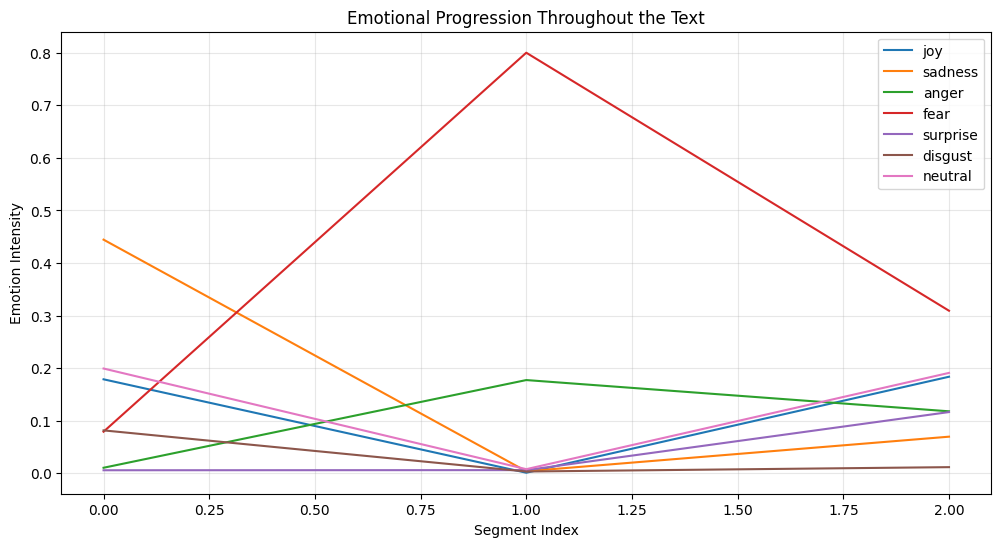


All music files generated successfully!


In [34]:
def demo():
    # Initialize the system
    music_generator = LiteraryMusicGenerator()

    # Example literary text (a short excerpt)
    example_text = """
    The morning dawned bright and clear, with a crispness in the air that promised a beautiful day ahead. Sarah smiled as she stepped outside, breathing in the fresh scent of wildflowers that carpeted the meadow beyond her cottage. It had been too long since she felt this sense of peace.

    Suddenly, dark clouds appeared on the horizon, rolling in with unexpected speed. The wind picked up, carrying with it the scent of rain and an undercurrent of foreboding. Sarah's smile faded as she watched the storm approach, her heart racing with a nameless anxiety.

    Lightning flashed, followed by a deafening crack of thunder that seemed to shake the very earth. Sarah ran back inside, slamming the door just as the rain began to pound against the windows like an angry fist demanding entry. She pressed her back against the door, breathing heavily, fighting the irrational fear that had gripped her.

    As quickly as it had arrived, the storm began to subside. The violent raindrops slowed to a gentle patter, and the thunder rumbled away into the distance. A ray of sunlight broke through the clouds, casting a golden glow over the rain-soaked landscape. Sarah felt her tension melting away, replaced by a profound sense of wonder at the resilience of nature and the beauty that can follow chaos.
    """

    # Process the text
    # Process the text
    result = music_generator.process_literary_text(example_text)

    # Display the results
    print("Text Processing Complete!")
    print(f"Text divided into {len(result['segments'])} segments")

    print("\nEmotional Progression:")
    for emotion, values in result['emotion_progression'].items():
        print(f"  {emotion}: {[round(v, 2) for v in values]}")

    print("\nMusicLM Prompts (now with actual music generation):")
    for i, prompt_data in enumerate(result['musiclm_prompts']):
        print(f"\nSegment {i+1}:")
        print(f"  Context: {prompt_data['context']}")
        print(f"  Dominant emotions: {prompt_data['dominant_emotions']}")
        print(f"  MusicLM prompt: {prompt_data['prompt']}")
        print(f"  Playing music for this segment...")
        display(play_midi_in_colab(result['midi_files'][i]))

    # Visualize emotional progression
    plot = music_generator.visualize_emotional_progression(result['emotion_progression'])
    plot.show()

    print("\nAll music files generated successfully!")

# Mock training data generator
def generate_mock_training_data(num_samples=100):
    """Generate synthetic data for training the models"""
    emotions = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust', 'neutral']
    musical_features = ['tempo', 'key', 'mode', 'intensity', 'instrumentation',
                         'rhythm_complexity', 'harmonic_complexity', 'melodic_range', 'texture', 'articulation']

    # Generate random emotion vectors
    emotion_vectors = np.random.rand(num_samples, len(emotions))
    # Normalize to sum to 1
    emotion_vectors = emotion_vectors / emotion_vectors.sum(axis=1, keepdims=True)

    # Generate matching musical features
    musical_feature_vectors = np.random.rand(num_samples, len(musical_features))

    # Create training dataset
    X_train = torch.tensor(emotion_vectors, dtype=torch.float32)
    y_train = torch.tensor(musical_feature_vectors, dtype=torch.float32)

    return X_train, y_train

# Training function for the emotion-to-music mapper
def train_emotion_to_music_mapper(model, num_epochs=100, batch_size=16):
    """Train the emotion-to-music mapping model"""
    # Generate mock training data
    X_train, y_train = generate_mock_training_data(500)

    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}')

    print("Training complete!")
    return model

# Training function for the temporal coherence model
def train_temporal_coherence_model(model, seq_length=5, num_epochs=100, batch_size=8):
    """Train the temporal coherence model"""
    # For simplicity, we'll generate sequences of musical features
    num_samples = 100
    feature_dim = 10

    # Generate sequences with some temporal patterns
    sequences = []
    for _ in range(num_samples):
        # Start with random features
        start_features = np.random.rand(feature_dim)
        # Generate a sequence with gradual changes
        sequence = [start_features]
        for i in range(1, seq_length):
            # Each step is a small random modification of the previous step
            next_features = sequence[i-1] + np.random.normal(0, 0.1, feature_dim)
            # Keep within bounds
            next_features = np.clip(next_features, 0, 1)
            sequence.append(next_features)
        sequences.append(sequence)

    # Convert to torch tensors
    X_train = torch.tensor(np.array(sequences), dtype=torch.float32)
    # Target is the same sequence (we want to learn the patterns)
    y_train = X_train.clone()

    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}')

    print("Training complete!")
    return model

# Main function to run everything
def main():
    # Initialize the system
    music_generator = LiteraryMusicGenerator()

    # Train models
    print("Training emotion-to-music mapper...")
    train_emotion_to_music_mapper(music_generator.emotion_to_music_mapper, num_epochs=50)

    print("\nTraining temporal coherence model...")
    train_temporal_coherence_model(music_generator.temporal_coherence_model, num_epochs=50)

    # Run demo
    print("\nRunning demonstration...")
    demo()

    # Save models
    torch.save(music_generator.emotion_to_music_mapper.state_dict(), 'emotion_to_music_mapper.pth')
    torch.save(music_generator.temporal_coherence_model.state_dict(), 'temporal_coherence_model.pth')
    print("\nModels saved successfully!")

# Function to save MIDI files to disk
def save_midi_files(midi_files, base_filename="segment"):
    """Save MIDI files to disk and download them"""
    saved_files = []

    for i, midi_buffer in enumerate(midi_files):
        filename = f"{base_filename}_{i+1}.mid"

        # Write to file
        with open(filename, 'wb') as f:
            f.write(midi_buffer.getvalue())

        saved_files.append(filename)

        # Initiate download in Colab
        try:
            files.download(filename)
        except:
            print(f"Note: Download of {filename} may not be supported in this environment.")

    return saved_files

# Function to combine all segments into a single music piece
def combine_segments(midi_files, output_filename="combined_music.mid"):
    """Combine all MIDI segments into a single continuous piece"""
    # Create a new MIDI file with more tracks to prevent conflicts
    combined_midi = MIDIFile(8)  # Increase number of tracks to avoid note overlaps

    # Add tempo to all tracks
    for track in range(8):
        combined_midi.addTempo(track, 0, 120)

    current_time = 0
    track_offset = 0  # To distribute notes across different tracks

    for midi_buffer in midi_files:
        # Create a temporary file to save the MIDI
        with tempfile.NamedTemporaryFile(suffix=".mid", delete=False) as temp_file:
            temp_file.write(midi_buffer.getvalue())
            temp_file_path = temp_file.name

        try:
            # Load the MIDI file
            midi_data = pretty_midi.PrettyMIDI(temp_file_path)

            # Get segment duration
            end_time = 0
            if midi_data.instruments:
                for instr in midi_data.instruments:
                    if instr.notes:
                        instr_end = max([note.end for note in instr.notes])
                        end_time = max(end_time, instr_end)

            if end_time == 0:
                end_time = 15  # Default duration if no notes found

            # Add each note from the segment to the combined file with offset
            for instr_idx, instr in enumerate(midi_data.instruments):
                # Use a different track for each instrument to avoid conflicts
                track = (track_offset + instr_idx) % 8
                program = instr.program

                # Set instrument
                combined_midi.addProgramChange(track, 0, current_time, program)

                # Add notes with time offset
                for note in instr.notes:
                    start = current_time + note.start
                    duration = note.end - note.start

                    # Ensure notes have valid duration
                    if duration <= 0:
                        duration = 0.1  # Set a minimum duration

                    pitch = note.pitch
                    velocity = note.velocity

                    combined_midi.addNote(track, 0, pitch, start, duration, velocity)

            # Increment the track offset for the next segment to use different tracks
            track_offset = (track_offset + len(midi_data.instruments)) % 8

        except Exception as e:
            print(f"Warning: Error processing segment: {e}")
        finally:
            # Remove the temporary file
            try:
                os.remove(temp_file_path)
            except:
                pass

        # Update current time for next segment
        current_time += end_time + 2  # Add 2 beat gap between segments

    # Save the combined MIDI
    try:
        with open(output_filename, 'wb') as output_file:
            combined_midi.writeFile(output_file)

        print(f"Successfully combined music saved to {output_filename}")

        # Initiate download in Colab
        try:
            files.download(output_filename)
        except:
            print(f"Note: Download of {output_filename} may not be supported in this environment.")

        return output_filename
    except Exception as e:
        print(f"Error saving combined file: {e}")
        return None

# Function to take user input and process it
def process_user_text():
    print("Please enter or paste your literary text (type 'END' on a new line when finished):")
    lines = []
    while True:
        line = input()
        if line.strip() == 'END':
            break
        lines.append(line)

    user_text = '\n'.join(lines)

    if not user_text.strip():
        print("No text entered. Using example text instead.")
        user_text = """
        The morning dawned bright and clear, with a crispness in the air that promised a beautiful day ahead.
        Sarah smiled as she stepped outside, breathing in the fresh scent of wildflowers that carpeted the meadow beyond her cottage.
        As she walked along the path, her mind wandered to thoughts of the past, memories both sweet and bitter.
        """

    # Process the text
    music_generator = LiteraryMusicGenerator()
    result = music_generator.process_literary_text(user_text)

    # Display results
    print(f"\nProcessed {len(result['segments'])} text segments")

    # Visualize emotional progression
    plot = music_generator.visualize_emotional_progression(result['emotion_progression'])
    plot.show()

    # Play music for each segment
    print("\nPlaying music for each segment:")
    for i, prompt_data in enumerate(result['musiclm_prompts']):
        print(f"\nSegment {i+1}:")
        emotions_display = []
        for e in prompt_data['dominant_emotions']:
            emotions_display.append(f"{e['emotion']} ({e['intensity']:.2f})")
        print(f"  Dominant emotions: {emotions_display}")
        print(f"  MusicLM prompt: {prompt_data['prompt']}")

        # Play the music
        display(play_midi_in_colab(result['midi_files'][i]))

    # Option to save MIDI files
    save_choice = input("\nWould you like to save the MIDI files? (y/n): ")
    if save_choice.lower() == 'y':
        saved_files = save_midi_files(result['midi_files'])
        print(f"Saved {len(saved_files)} MIDI files.")

        # Option to combine segments
        combine_choice = input("Would you like to combine all segments into one continuous piece? (y/n): ")
        if combine_choice.lower() == 'y':
            combined_file = combine_segments(result['midi_files'])
            print(f"Combined music saved to {combined_file}")

            # Play the combined piece
            print("\nPlaying the combined music piece:")
            with open(combined_file, 'rb') as f:
                combined_buffer = io.BytesIO(f.read())
            display(play_midi_in_colab(combined_buffer))

    # Save results to JSON
    output_data = {
        "segments": result['segments'],
        "emotion_progression": {k: [float(v) for v in vals] for k, vals in result['emotion_progression'].items()},
        "musiclm_prompts": result['musiclm_prompts']
    }

    with open('literary_music_results.json', 'w') as f:
        json.dump(output_data, f, indent=2)

    print("\nResults saved to 'literary_music_results.json'")
    try:
        files.download('literary_music_results.json')
    except:
        print("File download not supported in this environment.")

# Interface for Google Colab
def colab_interface():
    print("Literary Text to Music Converter")
    print("================================")
    print("1. Run demonstration with example text")
    print("2. Process your own literary text")
    print("3. Train models")
    print("4. Exit")

    choice = input("\nEnter your choice (1-4): ")

    if choice == '1':
        demo()
    elif choice == '2':
        process_user_text()
    elif choice == '3':
        main()
    elif choice == '4':
        print("Exiting...")
    else:
        print("Invalid choice. Please try again.")

# Run the Colab interface
if __name__ == "__main__":
    colab_interface()